
# Objective:
  ## To Detect Alzheimer Disease Based On MRI Scan USing Convolution Neural Network.

# What is Alzhiemer's?
Alzheimer's is the most common cause of dementia, a general term for memory loss and other cognitive abilities serious enough to interfere with daily life. Alzheimer's disease accounts for 60-80% of dementia cases.

# Dataset
 This work is done using a Kaggle dataset

Here is the link from where you can download the dataset
https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images




In [2]:
!nvidia-smi

Sat Jun 26 21:57:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [38]:
# Importing all dependencies which we will be using during the prediction

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization,Dropout,Flatten,Conv2D,MaxPooling2D
from sklearn.model_selection import train_test_split
import cv2
import zipfile
import os
from matplotlib import pyplot as plt
import random 
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import matplotlib.image as mpimg
from medpy.filter import smoothing
from tensorflow.keras.optimizers import RMSprop, Adam

from imblearn.over_sampling import SMOTE
from keras.models import Model

from keras.preprocessing import image

In [5]:
# Extracting all the folders from the Zip file
with zipfile.ZipFile('/content/drive/MyDrive/archive.zip','r') as zip_file:
  zip_file.extractall('')

In [6]:
# Loading the train dataset of each class
train_milddemented = ('/content/Alzheimer_s Dataset/train/MildDemented')
train_moderatedemented = ('/content/Alzheimer_s Dataset/train/ModerateDemented')
train_nondemented = ('/content/Alzheimer_s Dataset/train/NonDemented')
train_verymilddemented = ('/content/Alzheimer_s Dataset/train/VeryMildDemented')

# Plotting the Mild Dementia Images

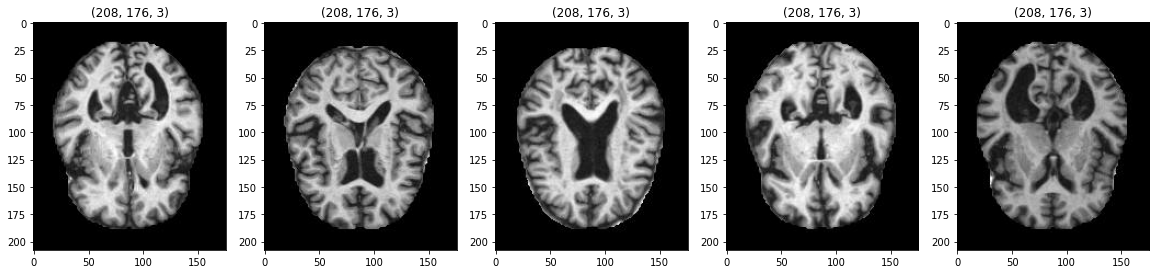

In [7]:
plt.figure(figsize=(20,20)) 
for i in range(5):
    file = random.choice(os.listdir(train_milddemented))
    image_path= os.path.join(train_milddemented, file)
    img=cv2.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    ax.title.set_text(img.shape)
    plt.imshow(img)


# Plotting the Moderate Dementia Images

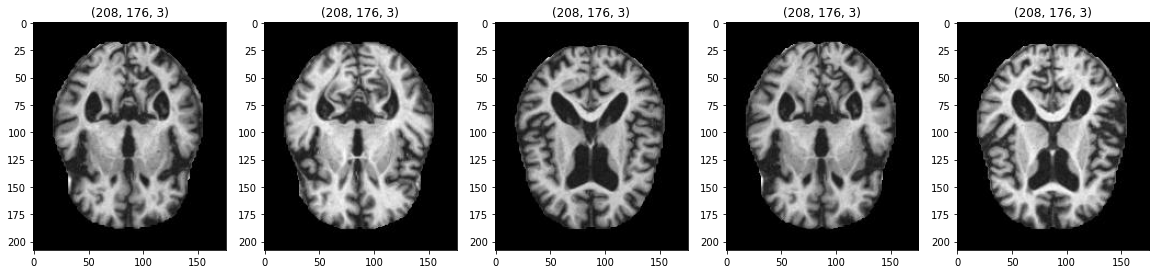

In [8]:
plt.figure(figsize=(20,20)) 
for i in range(5):
    file = random.choice(os.listdir(train_moderatedemented))
    image_path= os.path.join(train_moderatedemented, file)
    img=cv2.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    ax.title.set_text(img.shape)
    plt.imshow(img)

# Plotting the Non Dementia Images

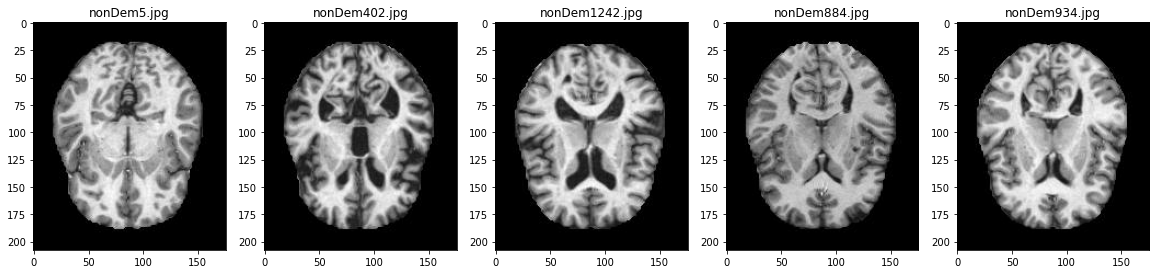

In [9]:
plt.figure(figsize=(20,20)) 
for i in range(5):
    file = random.choice(os.listdir(train_nondemented))
    image_path= os.path.join(train_nondemented, file)
    img=cv2.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

# Plotting the Very Mild Dementia Images

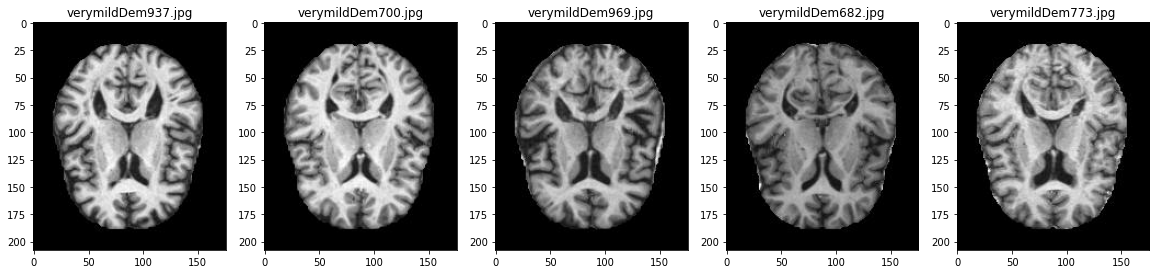

In [10]:
plt.figure(figsize=(20,20)) 
for i in range(5):
    file = random.choice(os.listdir(train_verymilddemented))
    image_path= os.path.join(train_verymilddemented, file)
    img=cv2.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [12]:
# Using Image Data Generator to get Some Random Transformated Images
datagen1 = ImageDataGenerator(rescale = 1./255,rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')
train = datagen1.flow_from_directory('/content/Alzheimer_s Dataset/train', target_size = (224,224),
                                    batch_size = 5200, color_mode='rgb')

Found 5121 images belonging to 4 classes.


In [13]:
datagen1 = ImageDataGenerator(rescale = 1./255)
test = datagen1.flow_from_directory('/content/Alzheimer_s Dataset/test', target_size = (224,224),
                                    batch_size = 1300, color_mode='rgb')

Found 1279 images belonging to 4 classes.


In [43]:
# Total Number of Classes 
train.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [21]:
# Creating a user defined function Which we will be using further to build our convolution Neural Network
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [22]:
# Creating a user Defined Function which contains convolution layers which will be used further to build our convolution Neural Network

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2))
    ]
    )
    
    return block

In [23]:
# Building Our model

def build_model():
    model = tf.keras.Sequential([
        
        
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', input_shape = (224,224,3)),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)
        
),
        
        conv_block(20),
        conv_block(50),
                                  
        
        #conv_block(96),
        #tf.keras.layers.Dropout(0.2),
                                  
        
        #conv_block(256),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
       # dense_block(512, 0.7),
        dense_block(128, 0.3),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    
    return model

In [24]:
model = build_model()

In [25]:
# Summary of the model

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)     

In [26]:
# Defining the metrics to check how our model is performing

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=METRICS)

In [27]:
# Splitting our data into features and labels
train_data, train_labels = train.next()
test_data,test_labels = test.next()

/usr/local/lib/python3.7/dist-packages/medpy/filter/smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/usr/local/lib/python3.7/dist-packages/medpy/filter/smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


In [28]:
print(train_data.shape)
print(test_data.shape)

(5121, 224, 224, 3)
(1279, 224, 224, 3)


In [29]:
#Performing over-sampling of the data, since the classes are imbalanced We will get some few more images using this oversampling method

sm=SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 224 * 224 * 3), train_labels)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [30]:
print(train_data.shape)
print(test_data.shape)

(10240, 150528)
(1279, 224, 224, 3)


In [31]:
# Reshaping the data back to size 224,224
train_data = train_data.reshape(-1, 224, 224, 3)

print(train_data.shape, train_labels.shape)


(10240, 224, 224, 3) (10240, 4)


In [32]:
tf.config.run_functions_eagerly(True)

In [33]:
# Fitting the model
history = model.fit(train_data, train_labels, validation_data=(test_data, test_labels), verbose =1 , epochs=20,batch_size= 32)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


320/320 [==============================] - 175s 500ms/step - loss: 1.3337 - accuracy: 0.7531 - precision: 0.5097 - recall: 0.3270 - auc: 0.7098 - val_loss: 1.8564 - val_accuracy: 0.7498 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4261
Epoch 2/20
320/320 [==============================] - 160s 499ms/step - loss: 0.8614 - accuracy: 0.8192 - precision: 0.6886 - recall: 0.5056 - auc: 0.8662 - val_loss: 1.8731 - val_accuracy: 0.6765 - val_precision: 0.1050 - val_recall: 0.0391 - val_auc: 0.3639
Epoch 3/20
320/320 [==============================] - 160s 499ms/step - loss: 0.6851 - accuracy: 0.8537 - precision: 0.7662 - recall: 0.5968 - auc: 0.9146 - val_loss: 2.3509 - val_accuracy: 0.6683 - val_precision: 0.2587 - val_recall: 0.1751 - val_auc: 0.5566
Epoch 4/20
320/320 [==============================] - 160s 499ms/step - loss: 0.5804 - accuracy: 0.8781 - precision: 0.8039 - recall: 0.6779 - auc: 0.9393 - val_loss: 1.6059 - val_accuracy: 0.6773 - val_precision: 0.3025 - 

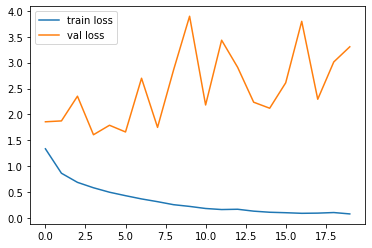

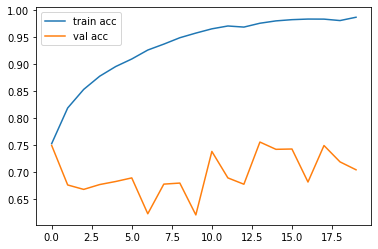

<Figure size 432x288 with 0 Axes>

In [35]:
# PLOTTING THE LOSS AND ACCURACY OF OUR MODEL

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [37]:
# Saving our model using the keras module

from keras.models import load_model

model.save('alzheimer.h5')

In [45]:
class_names = ['MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented']

This particular image most likely is :NonDemented


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


<function matplotlib.pyplot.show>

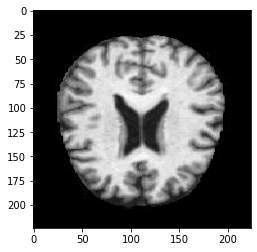

In [51]:
# Loading the saved model

saved_model = load_model('/content/alzheimer.h5')

# Predicting a random test Image
img = image.load_img('/content/Alzheimer_s Dataset/test/NonDemented/26 (62).jpg',target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
img_data = preprocess_input(x)
prediction = model.predict(img_data)
string = "This particular image most likely is :"+class_names[np.argmax(prediction)]
print(string)
plt.imshow(img)
plt.show